### Pending Refactor:
1. Map visualization in workbook
2. distance calculation part

In [336]:
import pandas as pd
import numpy as np
import pandas_gbq
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import distance
from datetime import timedelta, date, datetime
from google.cloud import bigquery

%load_ext google.cloud.bigquery
# Set your default project here
pandas_gbq.context.project = 'wmt-edw-sandbox'
pandas_gbq.context.dialect = 'standard'

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


#### Check delivery status (DLVR_STS)

In [27]:
%%bigquery test
select *,
    EXTRACT(HOUR FROM SLOT_START_TS_UTC AT TIME ZONE (CLNT_PCKUP_FROM_TZ_CD)) as LOCAL_SLOT_HOUR
from `wmt-edw-sandbox.LM_IAD_DAAS.DPS_DLVR_LAST_MI_DTL`
where SLA_Type = 'FRUGL'
    and BATCH_IND = 0
    and DLVR_PKG_SIZE_CD = 'S'
    and upper(DLVR_STS) is not null

Downloading: 100%|███████████████████████████████████████████████████████████| 62180/62180 [00:12<00:00, 4944.31rows/s]


In [28]:
test.DLVR_STS.value_counts()

CANCELLED                        56261
DELIVERED                         3423
INCOMPLETE AND NOT DISPATCHED     2069
FC RETURNED NONCHARGEABLE          158
RETURNED                           134
INCOMPLETE DELIVERED                53
FC DELIVERED CHARGEABLE             41
FC DELIVERED NONCHARGEABLE          19
INCOMPLETE RETURNED                 14
FC RETURNED CHARGEABLE               8
Name: DLVR_STS, dtype: int64

In [29]:
test.groupby(['DLVR_STS','CLNT_EXCPT_RSN_DESC'])['DLVR_TASK_ID'].nunique().reset_index().\
sort_values(['DLVR_TASK_ID'], ascending=False)
# most of cancelled are due to store issue/outage, won't generate a trip, can be ignored

,DLVR_STS,CLNT_EXCPT_RSN_DESC,DLVR_TASK_ID
75,CANCELLED,Store: Issue/Outage,53441
39,CANCELLED,Order: Not ready,533
11,CANCELLED,Customer: Converted to pickup,457
180,DELIVERED,Order: Not Ready,289
208,DELIVERED,Other,251
...,...,...,...
244,FC DELIVERED CHARGEABLE,"Driver dropped delivery due to app issue,Can't...",1
243,FC DELIVERED CHARGEABLE,"Can't Access,Order not ready",1
241,DELIVERED,"Unsafe Location,Other",1
240,DELIVERED,"Unsafe Location,Order: Not Ready",1


#### Check different sizes volume contribution

In [11]:
%%bigquery sizes
select DLVR_PKG_SIZE_CD,
    count(distinct DLVR_TASK_ID) as dlvr_cnt,
    count(distinct sales_order_nbr) as order_cnt
from `wmt-edw-sandbox.LM_IAD_DAAS.DPS_DLVR_LAST_MI_DTL`
where SLA_Type = 'FRUGL'
    and upper(DLVR_STS) in ('DELIVERED',
                            'RETURNED',
                            'INCOMPLETE DELIVERED',
                            'INCOMPLETE RETURNED')
group by 1

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.30rows/s]


In [18]:
sizes['dlvr_pct'] = sizes['dlvr_cnt'] /sizes['dlvr_cnt'].sum()
sizes

,DLVR_PKG_SIZE_CD,dlvr_cnt,order_cnt,dlvr_pct
0,S,554760,554488,0.945352
1,M,20705,20682,0.035283
2,L,8550,8540,0.014570
3,XL,2803,2803,0.004777
4,OVERSIZED,11,11,0.000019


## Define custom functions

In [393]:
def get_weekday(df, colname):
    '''create a new column in @df, with weekday name of @colname'''
    df[colname] = pd.to_datetime(df[colname])
    df[f'{colname}_day_nm'] = df[colname].dt.strftime('%A')
    return df


def get_range(df, colname):
    '''print and return min and max value of @colname in @df'''
    min_val = df[colname].min()
    max_val = df[colname].max()
    print(f"{colname} range from {min_val} to {max_val}")
    return min_val, max_val


def unbatch_group(df, colname):
    '''
    returns unbatched delivery percentage by @colname in @df
    '''
    total_cnt =  df.groupby(colname).DLVR_TASK_ID.nunique().reset_index().\
                    rename(columns={'DLVR_TASK_ID':'total_dlvr'})
    unbatched_cnt =  df[df.BATCH_IND == 0].groupby(colname).DLVR_TASK_ID.nunique().reset_index().\
                        rename(columns={'DLVR_TASK_ID':'unbatched_dlvr'})        
    merged = total_cnt.merge(unbatched_cnt, on=colname, how='left').fillna(0)
    merged['unbatched_pct'] = merged['unbatched_dlvr'] / merged['total_dlvr']
    merged.sort_values('unbatched_pct', ascending=False, inplace=True)
    return merged


def same_group_dlvr(df, timecol):
    '''add a column in @df for total delivery count in same store number and @timecol'''
    group_cols = ['STORE_NBR'] + timecol
    colname = '_'.join(timecol) 
    same_time = df.groupby(group_cols).DLVR_TASK_ID.nunique().reset_index().\
                        rename(columns={'DLVR_TASK_ID':f'same_{colname}_dlvr'})
    same_time[f'no_other_dlvr_{colname}_ind'] = (same_time[f'same_{colname}_dlvr'] == 1) * 1
    df_merge = df.merge(same_time, on=group_cols, how='left')
    return df_merge


def plot_unbatch(df, group_col, bar_col='unbatched_dlvr', line_col='unbatched_pct', top_n=None):
    '''
    plot a combined bar and line chart by @group_col in @df
    default bar chart: unbatched delivery count; line chart: unbatched pct
    '''
    if top_n is not None:
        df = df.head(top_n)
    
    fig, ax1 = plt.subplots()
    fig.set_size_inches(8, 4)
    
    # plot bar chart
    ax1.bar(df[group_col], df[bar_col], label=bar_col)
    ax1.set_xlabel(group_col)
    ax1.set_ylabel(bar_col)
    
    # plot line chart
    ax2 = ax1.twinx()
    ax2.plot(df[group_col], df[line_col], label=line_col, color='orange')
    ax2.set_ylabel(line_col)
    
    # formatting the legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines+lines2, labels+labels2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    fig.tight_layout()
    fig.autofmt_xdate(rotation=45)
    plt.show()
    
    
def get_dist(lat1, lon1, lat2, lon2):
    '''return geodesic distance in miles between (lat1, lon1) and (lat2, lon2)'''
    return distance.distance((lat1, lon1), (lat2, lon2)).miles

## Load Data: focus only on size 'S', and few DLVR_STS that might be batched

In [4]:
%%bigquery df
select *,
    EXTRACT(HOUR FROM SLOT_START_TS_UTC AT TIME ZONE (CLNT_PCKUP_FROM_TZ_CD)) as local_slot_hr_start,
    EXTRACT(HOUR FROM SLOT_END_TS_UTC AT TIME ZONE (CLNT_PCKUP_FROM_TZ_CD)) as local_slot_hr_end,
    DATE(SLOT_START_TS_UTC, CLNT_PCKUP_FROM_TZ_CD) as local_slot_dt
from `wmt-edw-sandbox.LM_IAD_DAAS.DPS_DLVR_LAST_MI_DTL`
where SLA_Type = 'FRUGL'
    and DLVR_PKG_SIZE_CD = 'S'
    and upper(DLVR_STS) in ('DELIVERED',
                            'RETURNED',
                            'INCOMPLETE DELIVERED',
                            'INCOMPLETE RETURNED')

Downloading: 100%|█████████████████████████████████████████████████████████| 567236/567236 [02:08<00:00, 4405.89rows/s]


In [5]:
df.shape

(567236, 374)

In [6]:
df = get_weekday(df, 'local_slot_dt')

In [7]:
# check date range
get_range(df, 'RPT_DT');
get_range(df, 'local_slot_dt')

RPT_DT range from 2023-04-20 to 2023-05-22
local_slot_dt range from 2023-04-20 00:00:00 to 2023-05-22 00:00:00


(Timestamp('2023-04-20 00:00:00'), Timestamp('2023-05-22 00:00:00'))

In [8]:
total = df.groupby('BATCH_IND')['DLVR_TASK_ID'].nunique().reset_index()
total['dlvr_pct'] = total['DLVR_TASK_ID'] / total['DLVR_TASK_ID'].sum()
total
# about 0.6% deliveries are unbatched, total 3402 deliveries

,BATCH_IND,DLVR_TASK_ID,dlvr_pct
0,0,3402,0.006132
1,1,551358,0.993868


## 1. Batched at first then got unbatched?

In [9]:
%%bigquery batched_at_first
select distinct SRC_SALES_ORDER_NUM
from `wmt-edw-prod.WW_SUPPLY_CHAIN_DL_SECURE.LAST_MI_DLVR_TRK_STATUS`  
where SRC_CRE_DT > '2023-04-01' 
    and DATA_SRC_CD = 'DAAS'
    and lower(EXCPT_RSN_DESC) like '%unbatch%'

Downloading: 100%|█████████████████████████████████████████████████████████████████| 111/111 [00:01<00:00, 58.76rows/s]


In [11]:
df = df.merge(batched_at_first, left_on='SALES_ORDER_NBR', right_on='SRC_SALES_ORDER_NUM', how='left')
# create an ind column
df['ever_batched'] = df['SRC_SALES_ORDER_NUM'].notnull() * 1

In [12]:
unbatch_group(df, 'ever_batched')
# only 51 deliveries in total, and 14 deliveries lead to unbatched as a result
# majority of the unbatched ones are unbatched at the very beginning

,ever_batched,total_dlvr,unbatched_dlvr,unbatched_pct
1,1,51,14,0.274510
0,0,554709,3388,0.006108


## 2. No other deliveries avaiable to be batched?

### 2.1 No other deliveries on the same day? (base on local slot hour start time)

In [13]:
df = same_group_dlvr(df, ['local_slot_dt'])

In [14]:
unbatch_group(df, 'no_other_dlvr_local_slot_dt_ind')

,no_other_dlvr_local_slot_dt_ind,total_dlvr,unbatched_dlvr,unbatched_pct
1,1,52,43,0.826923
0,0,554708,3359,0.006055


In [97]:
# total 52 deliveries have no other deliveries in the same day, 82.7% of which delivered unbatched
# which makes sense, the left deliveries could be batched with other sizes (M,L,XL)

### 2.2 No other deliveries on same day at same slot start hour? (base on local slot hour start time)

In [15]:
# take a look at local slot hour in general
slot_hr = unbatch_group(df, 'local_slot_hr_start')
slot_hr.sort_values('local_slot_hr_start', inplace=True)

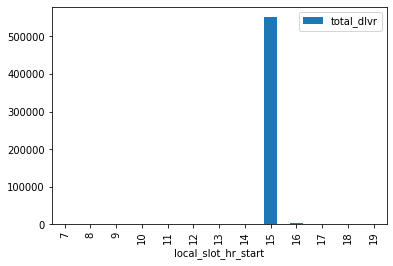

In [86]:
# total deliveries distribution, majority start at local 3pm
slot_hr.plot(kind='bar', x='local_slot_hr_start', y='total_dlvr');

In [430]:
# 99.4% are at 3PM
slot_hr.total_dlvr / slot_hr.total_dlvr.sum()

0     0.000187
1     0.000014
2     0.001303
3     0.000038
4     0.000025
5     0.000124
6     0.000014
7     0.000025
8     0.994223
9     0.003389
10    0.000431
11    0.000196
12    0.000029
Name: total_dlvr, dtype: float64

In [125]:
# check local slot end time, all end as local 11pm, actually 11:59:59, which is end of the day.
# no difference, can ignore this feature
unbatch_group(df, 'local_slot_hr_end')

,local_slot_hr_end,total_dlvr,unbatched_dlvr,unbatched_pct
0,23,554760,3402,0.006132


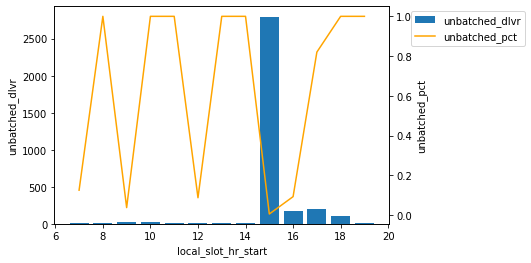

In [98]:
# unbatched deliveries and percentage
plot_unbatch(slot_hr,'local_slot_hr_start')

In [122]:
slot_hr[slot_hr.local_slot_hr_start != 15].sum()

local_slot_hr_start     154.000000
total_dlvr             3205.000000
unbatched_dlvr          606.000000
unbatched_pct             8.161938
dtype: float64

In [ ]:
# 606 unbatched deliveries outside of local slot hour start at 3pm
# might worth to find out why those trips got assigned an abnormal local slot hour start time

In [123]:
# any stores with high non-15 local slot hour unbatched?
df[(df.local_slot_hr_start != 15) & (df.BATCH_IND == 0)].groupby('EXT_STORE_NBR').DLVR_TASK_ID.nunique().reset_index().\
    sort_values('DLVR_TASK_ID', ascending=False)

,EXT_STORE_NBR,DLVR_TASK_ID
11,4750,18
79,6328,13
186,8157,12
143,6624,11
194,8182,10
...,...,...
97,6380,1
98,6381,1
108,6418,1
110,6424,1


In [ ]:
# not really, quite evenly distributed across stores

In [115]:
# sample data in non-15 slot hours
df[(df.local_slot_hr_start != 15) & (df.BATCH_IND == 0)].sample(10).to_clipboard()

In [116]:
# sample data in non-15 slot hours
df[(df.STORE_NBR == 100802) & (df.local_slot_dt == pd.to_datetime('2023-05-09'))].to_clipboard()

In [ ]:
# since non-15 local slot hour start is abnormal, is it no other deliveries at the same time lead to unbatch?

In [124]:
df = same_group_dlvr(df, ['local_slot_dt','local_slot_hr_start'])

In [129]:
slot_day_hr = unbatch_group(df, 'no_other_dlvr_local_slot_dt_local_slot_hr_start_ind')
slot_day_hr
# very high percentage untached pct, which follows common sense.
# note those 43 unbatched deliveries with no others in same slot day are included in 306 here. 

,no_other_dlvr_local_slot_dt_local_slot_hr_start_ind,total_dlvr,unbatched_dlvr,unbatched_pct
1,1,344,306,0.889535
0,0,554416,3096,0.005584


In [130]:
df['local_slot_hr_start_15_ind'] = (df['local_slot_hr_start'] == 15) * 1

In [131]:
unbatch_group(df, ['local_slot_hr_start_15_ind','no_other_dlvr_local_slot_dt_local_slot_hr_start_ind'])

,local_slot_hr_start_15_ind,no_other_dlvr_local_slot_dt_local_slot_hr_start_ind,total_dlvr,unbatched_dlvr,unbatched_pct
1,0,1,290,261,0.900000
3,1,1,54,45,0.833333
0,0,0,2915,345,0.118353
2,1,0,551501,2751,0.004988


In [ ]:
# we can see most of deliveries (290/344) with no other deliveris in the same slot hour came from slot hour outside 3pm
# no other deliveries to batch is a stronger factor vs. local slot hour outside 3pm
# but we can also see 11.8% outside 3pm slot hour, with other deliveries are unbatched, which is much higher than network's 0.6%

## 3. Distance to other delivery addresses are too far?

[transform to generate array, go around method](https://stackoverflow.com/questions/62458837/groupby-transform-to-list-in-pandas-does-not-work)

In [132]:
df.to_csv(r'C:\Users\y0q00wv\Documents\Roger Qin\Data Analytics\GoLocal\Ad hoc analysis\temp_data_saver.csv')

In [153]:
df['cust_lat'] = df['CUST_RQ_DLVR_LAT_NBR'].astype(float)
df['cust_lon'] = df['CUST_RQ_DLVR_LONG_NBR'].astype(float)

In [211]:
test_data = df[(df.STORE_NBR == 100802) & (df.local_slot_dt == pd.to_datetime('2023-05-09'))].copy()
test_grouped_data = test_data.groupby(['STORE_NBR','local_slot_dt','local_slot_hr_start'])

In [223]:
test_data['all_cust_lat_in_group'] = test_grouped_data['cust_lat'].transform(lambda x : [x.tolist()]*len(x))
test_data['all_cust_lon_in_group'] = test_grouped_data['cust_lon'].transform(lambda x : [x.tolist()]*len(x))
test_data

,late_reason_2,late_reason_1,DWT,TENANT_NM,TENANT_ID,STORE_NM,EXT_STORE_NBR,CITY_NM,DLVR_AREA_NM,DLVR_REGION_NM,...,ever_batched,same_local_slot_dt_dlvr,no_other_dlvr_local_slot_dt_ind,same_local_slot_dt_local_slot_hr_start_dlvr,no_other_dlvr_local_slot_dt_local_slot_hr_start_ind,local_slot_hr_start_15_ind,cust_lat,cust_lon,all_cust_lat_in_group,all_cust_lon_in_group
369448,None,None,4.583333,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,53,0,1,32.614442,-97.094580,"[32.614442, 32.625231, 32.580521, 32.699353, 3...","[-97.09458, -97.08323, -96.925966, -97.089577,..."
369455,None,None,4.583333,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,53,0,1,32.625231,-97.083230,"[32.614442, 32.625231, 32.580521, 32.699353, 3...","[-97.09458, -97.08323, -96.925966, -97.089577,..."
369524,None,None,1.516667,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,53,0,1,32.580521,-96.925966,"[32.614442, 32.625231, 32.580521, 32.699353, 3...","[-97.09458, -97.08323, -96.925966, -97.089577,..."
369542,None,None,6.383333,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,53,0,1,32.699353,-97.089577,"[32.614442, 32.625231, 32.580521, 32.699353, 3...","[-97.09458, -97.08323, -96.925966, -97.089577,..."
369578,None,None,3.616667,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,5,0,0,32.682429,-96.839183,"[32.682429, 32.621565, 32.707914, 32.72998, 32...","[-96.839183, -96.82599, -96.876715, -96.859572..."
370238,None,None,1.200000,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,53,0,1,32.648913,-96.898624,"[32.614442, 32.625231, 32.580521, 32.699353, 3...","[-97.09458, -97.08323, -96.925966, -97.089577,..."
370319,None,None,12.083333,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,53,0,1,32.587738,-97.041254,"[32.614442, 32.625231, 32.580521, 32.699353, 3...","[-97.09458, -97.08323, -96.925966, -97.089577,..."
370421,None,None,4.583333,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,53,0,1,32.636632,-97.163306,"[32.614442, 32.625231, 32.580521, 32.699353, 3...","[-97.09458, -97.08323, -96.925966, -97.089577,..."
370440,None,None,19.983333,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,53,0,1,32.824942,-97.098363,"[32.614442, 32.625231, 32.580521, 32.699353, 3...","[-97.09458, -97.08323, -96.925966, -97.089577,..."
370638,None,None,5.216667,Sam's Club,2,Sam's Club #8269,8269,Grand Prairie,Walmart Fort Worth,"Dallas-Fort Worth-Arlington, TX",...,0,60,0,53,0,1,32.568157,-97.132446,"[32.614442, 32.625231, 32.580521, 32.699353, 3...","[-97.09458, -97.08323, -96.925966, -97.089577,..."


In [242]:
def get_min_dist(lat1, lon1, lat_array, lon_array):
    assert len(lat_array) == len(lon_array)
    min_dist = float('inf') # initiate with max value in float
    
    for i, lat2 in enumerate(lat_array):
        lon2 = lon_array[i]
        if ((lat1 == lat2) & (lon1 == lon2)): # same coordinate, skip
            continue
        else:
            dist = get_dist(lat1, lon1, lat2, lon2)
            min_dist = min(dist, min_dist)
    return min_dist

def generate_min_dist_col(df):
    '''
    returns a column in @df, for each delivery, 
    it shows the min distance from other deliveries addresses in same slot date, same local slot hour
    '''
    # create grouped object
    grouped = df.groupby(['STORE_NBR','local_slot_dt','local_slot_hr_start'])
    
    # generate lat and long arrays
    df['all_cust_lat_in_group'] = grouped['cust_lat'].transform(lambda x : [x.tolist()]*len(x))
    df['all_cust_lon_in_group'] = grouped['cust_lon'].transform(lambda x : [x.tolist()]*len(x))
    
    # calculate min dist
    res = df.apply(lambda x: get_min_dist(x['cust_lat'], 
                                                                           x['cust_lon'], 
                                                                           x['all_cust_lat_in_group'], 
                                                                           x['all_cust_lon_in_group']), 
                                                    axis=1)
    return res

In [244]:
test_data['min_dist_to_other_dlvr_addr'] = generate_min_dist_col(test_data)

<AxesSubplot: ylabel='Frequency'>

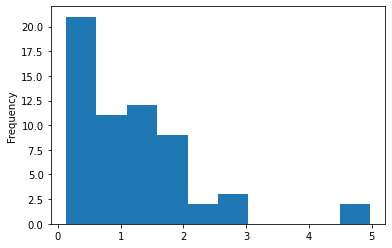

In [249]:
test_data['min_dist_to_other_dlvr_addr'].plot(kind='hist')

In [255]:
test_data[['SALES_ORDER_NBR','BATCH_IND',
           'local_slot_hr_start',
           'no_other_dlvr_local_slot_dt_local_slot_hr_start_ind',
           'min_dist_to_other_dlvr_addr']].sort_values('min_dist_to_other_dlvr_addr',
                                                                                    ascending=False)
# slot hour 16 and 17 addresses are not very far, need to viz on map to see

,SALES_ORDER_NBR,BATCH_IND,local_slot_hr_start,no_other_dlvr_local_slot_dt_local_slot_hr_start_ind,min_dist_to_other_dlvr_addr
369524,10064262594-001,1,15,0,4.975256
371712,10064236533-002,1,15,0,4.718191
376169,10064343779-001,1,15,0,2.879280
370238,10064166319-001,1,15,0,2.747815
371363,10064301835-001,0,16,0,2.631501
375412,10064250445-001,1,15,0,2.442150
373474,10064284269-001,1,15,0,2.294168
371655,10064262177-001,1,15,0,1.909228
374380,10064373121-001,0,16,0,1.819164
373397,10064357263-001,0,16,0,1.819164


In [258]:
# need to exclude null lat longs first
df_geo = df.dropna(subset=['cust_lat'])

In [260]:
# cust_lon also clean
df_geo.cust_lon.isnull().sum()

0

In [262]:
df_geo['min_dist_to_other_dlvr_addr'] = generate_min_dist_col(df_geo)

<ipython-input-242-e33c1c0ce7c3>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['all_cust_lat_in_group'] = grouped['cust_lat'].transform(lambda x : [x.tolist()]*len(x))
<ipython-input-242-e33c1c0ce7c3>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['all_cust_lon_in_group'] = grouped['cust_lon'].transform(lambda x : [x.tolist()]*len(x))
<ipython-input-262-c86bbcbb0298>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [264]:
df_geo['min_dist_to_other_dlvr_addr'].describe()

count    5.663650e+05
mean              inf
std               NaN
min      6.892336e-05
25%      6.270908e-01
50%      1.126996e+00
75%      1.882685e+00
max               inf
Name: min_dist_to_other_dlvr_addr, dtype: float64

In [268]:
# Need to remove 'inf' lines, most are no other deliveries, few with other deliveries, but no lat lon for other deliveries
df_geo[df_geo['min_dist_to_other_dlvr_addr'] == float('inf')]['no_other_dlvr_local_slot_dt_local_slot_hr_start_ind'].value_counts()

1    352
0      9
Name: no_other_dlvr_local_slot_dt_local_slot_hr_start_ind, dtype: int64

In [270]:
df_clean = df_geo[df_geo['min_dist_to_other_dlvr_addr'] != float('inf')].copy()

In [289]:
# returned ones, never reached to customer address, cust_lat and lon might be incorrect
# delivered ones, pkg drop off lat lon seems correct, cust_lat lon might be incorrect
df_clean[df_clean['min_dist_to_other_dlvr_addr'] > 100][['SALES_ORDER_NBR','DLVR_STS',
                                                          'PKG_DROPOFF_LOC_LAT_NUM','PKG_DROPOFF_LOC_LONG_NUM',
                                                          'cust_lat','cust_lon','all_cust_lat_in_group','all_cust_lon_in_group']]

,SALES_ORDER_NBR,DLVR_STS,PKG_DROPOFF_LOC_LAT_NUM,PKG_DROPOFF_LOC_LONG_NUM,cust_lat,cust_lon,all_cust_lat_in_group,all_cust_lon_in_group
17707,10064268971-001,RETURNED,None,None,39.889669,-76.972800,"[41.672797, 41.758153, 41.858884, 41.923274, 3...","[-111.870855, -111.79633, -111.986134, -111.79..."
66253,10064679218-001,DELIVERED,41.762786865,-112.009775104,39.889669,-76.972800,"[41.663631, 41.625148, 41.716273, 41.623574, 4...","[-111.842745, -111.820143, -111.842908, -111.8..."
128653,10060683608-002,RETURNED,None,None,14.599512,120.984219,"[39.094536, 39.052438, 38.936159, 39.046042, 3...","[-77.512948, -77.379395, -77.547573, -77.39185..."
129204,10060641757-001,DELIVERED,40.219635010,-79.627421884,41.203322,-77.194525,"[40.325606, 40.412109, 40.301094, 40.360025, 4...","[-79.674525, -79.566907, -79.552234, -79.60029..."
181079,10065671811-001,RETURNED,None,None,6.927079,79.861243,"[39.053312, 39.01, 39.036446, 38.972115, 39.11...","[-77.354718, -77.43, -77.480549, -77.584911, -..."
338731,10059753703-001,RETURNED,None,None,14.599512,120.984219,"[39.091152, 38.962422, 14.599512, 39.004292, 3...","[-77.581039, -77.43812, 120.984219, -77.381451..."
382057,10062024054-001,DELIVERED,26.151305000,-97.652187600,29.461720,-96.940350,"[26.159801, 26.204153, 26.221495, 26.18718, 26...","[-97.80268, -97.721648, -97.680544, -97.783144..."
433201,10060912255-001,DELIVERED,37.052770300,-94.373677000,37.964253,-91.831833,"[37.049477, 37.172189, 37.160794, 36.980913, 3...","[-94.562402, -94.574705, -94.482752, -94.31708..."


In [321]:
# check 90% quantile of drive miles for trip, to decide a reasonable "far" distance threshold
df_clean['driver_dist_mile'] = df_clean['DISTN_DRVN_MI_QTY'].astype(float)
drive_dist = df_clean[df_clean['DLVR_STS'] == 'DELIVERED'].groupby(['DLVR_TASK_ID'])['driver_dist_mile'].sum()
drive_dist.quantile(.9)

9.35163355

In [347]:
# use two thresholds to split data into 3 parts
df_outlier = df_clean[df_clean['min_dist_to_other_dlvr_addr'] > 100]

df_far = df_clean[(df_clean['min_dist_to_other_dlvr_addr'] >= 10) & 
                  (df_clean['min_dist_to_other_dlvr_addr'] <= 100)]

df_normal = df_clean[df_clean['min_dist_to_other_dlvr_addr'] < 10]


def condition(x):
    if x > 100:
        return '>100 miles'
    elif x < 10:
        return "<10 miles"
    else:
        return "10 - 100 miles"
    
df_clean['min_dist_to_others_far_group'] = df_clean['min_dist_to_other_dlvr_addr'].apply(condition)

In [323]:
df_normal.groupby('BATCH_IND')['min_dist_to_other_dlvr_addr'].describe()

,count,mean,std,min,25%,50%,75%,max
BATCH_IND,,,,,,,,
0,3007.0,2.548621,1.980488,0.029830,1.146764,1.942066,3.398793,9.981665
1,562403.0,1.441297,1.211825,0.000069,0.625071,1.122253,1.871214,9.998786


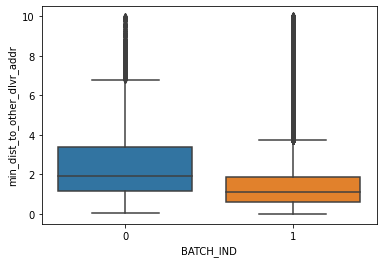

In [341]:
sns.boxplot(data=df_normal, x='BATCH_IND', y='min_dist_to_other_dlvr_addr');

In [343]:
# we can see unbatched deliveries have longer distance with other delivery addresses in the same slot hour

In [348]:
unbatch_group(df_clean, 'min_dist_to_others_far_group')

,min_dist_to_others_far_group,total_dlvr,unbatched_dlvr,unbatched_pct
2,>100 miles,8,8,1.000000
0,10 - 100 miles,575,106,0.184348
1,<10 miles,552968,2968,0.005367


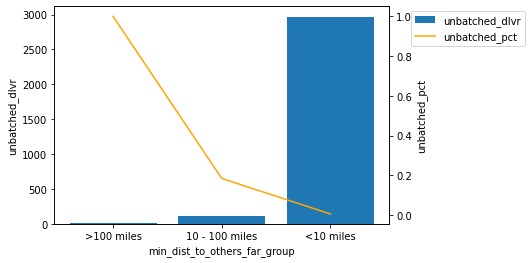

In [349]:
plot_unbatch(unbatch_group(df_clean, 'min_dist_to_others_far_group'), 'min_dist_to_others_far_group')

In [358]:
df_clean['min_dist_to_other_group'] = pd.cut(df_clean['min_dist_to_other_dlvr_addr'], 
                                                 bins=[0,1,2,3,4,5,6,7,8,9,10,100,10000])
df_clean['min_dist_to_other_group'] = df_clean['min_dist_to_other_group'].astype(str)

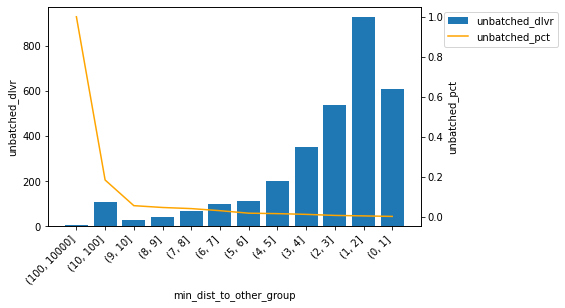

In [400]:
plot_unbatch(unbatch_group(df_clean, 'min_dist_to_other_group'), 'min_dist_to_other_group')

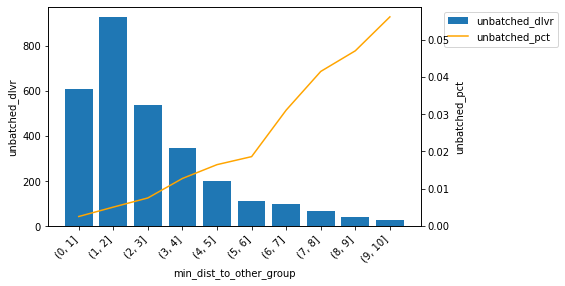

In [433]:
plot_unbatch(unbatch_group(df_clean[df_clean['min_dist_to_other_dlvr_addr'] < 10], 'min_dist_to_other_group').sort_values('unbatched_pct'), 
             'min_dist_to_other_group')

In [432]:
unbatch_group(df_clean[df_clean['min_dist_to_other_dlvr_addr'] < 10], 'min_dist_to_other_group')

,min_dist_to_other_group,total_dlvr,unbatched_dlvr,unbatched_pct
9,"(9, 10]",516,29,0.056202
8,"(8, 9]",871,41,0.047072
7,"(7, 8]",1686,70,0.041518
6,"(6, 7]",3150,98,0.031111
5,"(5, 6]",5970,111,0.018593
4,"(4, 5]",12168,200,0.016437
3,"(3, 4]",27436,349,0.012721
2,"(2, 3]",72097,539,0.007476
1,"(1, 2]",184628,925,0.005010
0,"(0, 1]",244446,606,0.002479


In [360]:
# untached rate and distance to other addresses are positively correlated

In [436]:
# df_clean has no overlap with time limitation check in section 2
unbatch_group(df_clean, 'no_other_dlvr_local_slot_dt_local_slot_hr_start_ind')

,no_other_dlvr_local_slot_dt_local_slot_hr_start_ind,total_dlvr,unbatched_dlvr,unbatched_pct
0,0,553551,3082,0.005568


In [437]:
# if we take 6 mile as a threshold, how many unbatched can be explained by distance?
df_clean[(df_clean['min_dist_to_other_dlvr_addr'] >= 6) & 
        (df_clean['BATCH_IND'] == 0)].DLVR_TASK_ID.nunique()

352

In [439]:
# df_clean has no overlap with time limitation check in section 2
unbatch_group(df_clean, ['local_slot_hr_start_15_ind','min_dist_to_other_group']).to_clipboard()

## 4. Any specific factor contributes a lot?

In [387]:
df['EXT_STORE_NBR'] = df['EXT_STORE_NBR'].astype(str)
stores = unbatch_group(df, 'EXT_STORE_NBR')

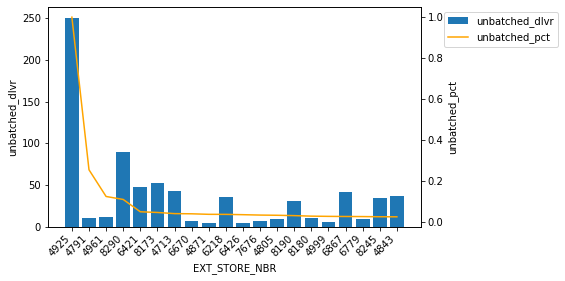

In [394]:
plot_unbatch(stores, 'EXT_STORE_NBR', top_n=20)

In [ ]:
# sams club #4925 has all its deliveries unbatched

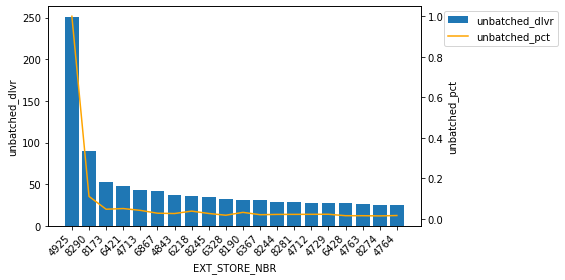

In [397]:
stores.sort_values('unbatched_dlvr', ascending=False, inplace=True)
plot_unbatch(stores, 'EXT_STORE_NBR', top_n=20)

In [ ]:
# also take a look at sams club 8290 and 8173

In [ ]:
focus_stores = df[df['EXT_STORE_NBR'].isin(['4925','8173','8290'])]
# save to local as data source behind tableau
focus_stores.to_csv(r'C:\Users\y0q00wv\Documents\Roger Qin\Data Analytics\GoLocal\Ad hoc analysis\focus_stores.csv',
                   index=False)

In [423]:
focus_stores_grouped = unbatch_group(focus_stores, ['EXT_STORE_NBR', 'local_slot_dt'])
focus_stores_grouped.sort_values(['EXT_STORE_NBR','unbatched_dlvr'], ascending=False, inplace=True)

In [424]:
focus_stores_grouped.groupby('EXT_STORE_NBR').head(3)

,EXT_STORE_NBR,local_slot_dt,total_dlvr,unbatched_dlvr,unbatched_pct
82,8290,2023-05-06,58,27.0,0.465517
97,8290,2023-05-21,50,23.0,0.460000
83,8290,2023-05-07,39,10.0,0.256410
40,8173,2023-04-27,33,7.0,0.212121
44,8173,2023-05-01,48,7.0,0.145833
47,8173,2023-05-04,44,7.0,0.159091
14,4925,2023-05-04,28,28.0,1.000000
18,4925,2023-05-08,13,13.0,1.000000
12,4925,2023-05-02,12,12.0,1.000000


In [435]:
focus_stores_grouped.groupby('EXT_STORE_NBR').mean()

,total_dlvr,unbatched_dlvr,unbatched_pct
EXT_STORE_NBR,,,
4925,7.606061,7.606061,1.000000
8173,33.151515,1.606061,0.046604
8290,24.393939,2.727273,0.072686


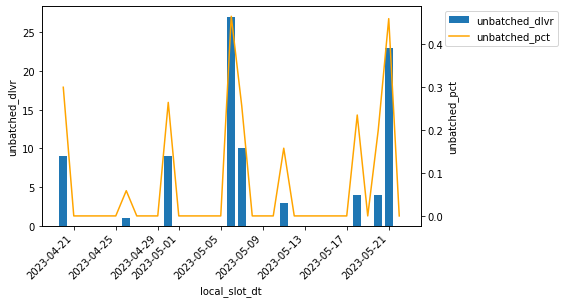

In [417]:
plot_unbatch(focus_stores_grouped[focus_stores_grouped['EXT_STORE_NBR'] == '8290'], 'local_slot_dt')

## Sample Data Share
In case business team want to deep dive further

In [459]:
file_path = r'C:\Users\y0q00wv\Documents\Roger Qin\Data Analytics\GoLocal\Ad hoc analysis\FRUGL Small Deliveries Unbatched Analysis'

sample_data_col_list = ['EXT_STORE_NBR',
                  'DLVR_AREA_NM',
                  'SALES_ORDER_NBR',
                  'TRIP_ID',
                  'BATCH_ID',
                    'BATCH_IND',
                   'BATCH_SIZE',
                   'DLVR_STS',
                  'ORDER_PLCD_DT',
                  'SLOT_START_TS_UTC',
                  'CLNT_PCKUP_FROM_TZ_CD',
                  'local_slot_hr_start',
                  'local_slot_hr_start_15_ind',
                   'local_slot_dt',
                    'same_local_slot_dt_local_slot_hr_start_dlvr',
                    'no_other_dlvr_local_slot_dt_local_slot_hr_start_ind']

geo_col_list = ['CUST_RQ_DLVR_LAT_NBR',
                  'CUST_RQ_DLVR_LONG_NBR',
                  'PKG_DROPOFF_LOC_LAT_NUM',
                  'PKG_DROPOFF_LOC_LONG_NUM',
                   'STORE_LAT_NBR',
                   'STORE_LONG_NBR',
                  'min_dist_to_other_dlvr_addr']

#### 1. Batched at first then Unbatched 

In [460]:
file_name = 'batched at first then unbatched'

df[(df['ever_batched'] == 1) & (df['BATCH_IND'] == 0)][sample_data_col_list].to_csv(f'{file_path}/{file_name}.csv', index=False)

#### 2. No other deliveries on same day same local slot start hour

In [461]:
file_name = 'No other deliveries on same day same local slot start hour'

df[(df['no_other_dlvr_local_slot_dt_local_slot_hr_start_ind'] == 1) & (df['BATCH_IND'] == 0)][sample_data_col_list].to_csv(f'{file_path}/{file_name}.csv', index=False)

#### 3. No other deliveries within at least 6 miles 

In [462]:
file_name = 'No other deliveries within at least 6 miles'
df_clean[(df_clean['min_dist_to_other_dlvr_addr'] >= 6) & (df_clean['BATCH_IND'] == 0)][sample_data_col_list + geo_col_list].to_csv(f'{file_path}/{file_name}.csv', index=False)

#### 4. Local slot start hour not 3pm

In [463]:
file_name = 'Local slot start hour not 3pm'

df[(df['local_slot_hr_start_15_ind'] == 0)][sample_data_col_list].to_csv(f'{file_path}/{file_name}.csv', index=False)

#### 5. Sam's Club 4925, 8173, 8290

In [464]:
file_name = "Sample Sam's Club"

df_clean[df_clean['EXT_STORE_NBR'].isin(['4925','8173','8290'])][sample_data_col_list + geo_col_list].to_csv(f'{file_path}/{file_name}.csv', index=False)